# Notebook options

In [1]:
grid_search = True
save_model = True
training_mode = 'normal'

# Imports and display options

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from hypopt import GridSearch
from preprocessing import get_df
from preprocessing import scale
from persistence import model_saver
from evaluation import score_model, plot_performance
import time

/glade/u/home/jdubeau/github/rda-ML-resource/venv/lib/python3.8/site-packages/hypopt/model_selection.py:39: UserWarning: If you want to see estimated completion times
    while running methods in cleanlab.pruning, install tqdm
    via "pip install tqdm".
  warnings.warn(w)


In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 75

# Load data

In [4]:
df = get_df()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50360 entries, 6132011 to 6785810
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   rinfo            50360 non-null  object             
 1   request_type     50360 non-null  object             
 2   job_start_at     50360 non-null  datetime64[ns]     
 3   job_end_at       50360 non-null  datetime64[ns]     
 4   req_mem          50360 non-null  float64            
 5   used_mem         50360 non-null  float64            
 6   dsnum            48150 non-null  object             
 7   rqst_start_at    50327 non-null  datetime64[ns, UTC]
 8   rqst_end_at      50248 non-null  datetime64[ns, UTC]
 9   dates_init       50360 non-null  bool               
 10  slat             32123 non-null  float64            
 11  nlat             32123 non-null  float64            
 12  wlon             32140 non-null  float64            
 13  elon    

# Wall time models

## Feature selection

In [6]:
X_features = ['PP', 'SP', 'BR', 'rqst_timespan', 'rqst_area_rect', 'converted',
              'params_num', 'grid_def_num', 'level_num',
              'ds084.1', 'ds631.1', 'ds083.3', 'ds094.0', 'ds083.2']
y_features = ['wall_time']

X = df[X_features]
y = df[y_features]

In [7]:
df.shape

(50360, 39)

## Train/validation/test split

In [8]:
train_amt = 0.5
val_amt = 0.25
test_amt = 0.25

In [9]:
X_train, X_target, y_train_full, y_target_full = \
                train_test_split(X, y, 
                test_size=1-train_amt, 
                random_state = 3)
X_val, X_test,y_val_full, y_test_full = \
                train_test_split(X_target, y_target_full,
                                 test_size = test_amt/train_amt,
                                 random_state = 3)


In [10]:
y_train = np.ravel(y_train_full)
y_val = np.ravel(y_val_full)
y_test = np.ravel(y_test_full)

In [11]:
log_y_train = np.log10(y_train)
log_y_val = np.log10(y_val)
log_y_test = np.log10(y_test)

## Scaling

In [12]:
X_train_norm, X_val_norm, X_test_norm = \
        scale(X_train, X_val, X_test)

## Trees, Forest, Gradient Boosts

### Tree

In [12]:
if grid_search:
    tree_param_grid = {'random_state':[3], 'max_depth':range(2,15)}
    tree_gs = GridSearch(model=DecisionTreeRegressor(), 
                              param_grid=tree_param_grid,
                              parallelize=False)
    tree_gs.fit(X_train_norm, y_train, X_val_norm, y_val)
    print(tree_gs.best_params)
    tree = tree_gs.best_estimator_
    
else:
    tree_params = {'max_depth': 14, 'random_state': 3}
    tree = DecisionTreeRegressor(**tree_params)
    tree.fit(X_train_norm, y_train)

### Forest

In [18]:
if grid_search:
    start = time.time()
    forest_param_grid = {'random_state':[3], 'max_depth':range(2,15),
                              'n_jobs':[20],
                              'n_estimators':[50, 75, 100, 125, 150, 
                                              175, 200, 225, 250],
                              'min_samples_split':range(5,30, 5)}
    forest_gs = GridSearch(model=RandomForestRegressor(), 
                                param_grid=forest_param_grid,
                                parallelize=False)
    forest_gs.fit(X_train_norm, log_y_train, X_val_norm, log_y_val)
    end = time.time()
    print(f"Time = {end-start}")
    print(forest_gs.best_params)
    forest = forest_gs.best_estimator_
    
else:
    forest_params = {'max_depth': 14, 'n_estimators': 250,
                     'min_samples_split':5, 'random_state': 3}
    forest = RandomForestRegressor(**forest_params)
    forest.fit(X_train_norm, log_y_train)

Time = 221.86210823059082
{'max_depth': 14, 'min_samples_split': 5, 'n_estimators': 250, 'n_jobs': 20, 'random_state': 3}


### Gradient boosted trees

In [14]:
if grid_search:
    start = time.time()
    gboost_param_grid = {'random_state':[3], 
                         'max_depth':range(2,15),
                         'n_estimators':range(50,300,50)}
    gboost_gs = GridSearch(model=GradientBoostingRegressor(),
                                param_grid=gboost_param_grid,
                                parallelize=False)
    gboost_gs.fit(X_train_norm, log_y_train, X_val_norm, log_y_val)
    end = time.time()
    print(f"Time = {end-start}")
    print(gboost_gs.best_params)
    gboost = gboost_gs.best_estimator_

else:
    gboost_params = {'max_depth': 1, 'n_estimators': 200, 'random_state': 3}
    gboost = GradientBoostingRegressor(**gboost_params)
    gboost.fit(X_train_norm, log_y_train)

Time = 282.89883685112
{'max_depth': 11, 'n_estimators': 200, 'random_state': 3}


In [15]:
if grid_search:
    hist_gboost_param_grid = {'random_state':[3],
                               'max_depth':range(8,20),
                               'min_samples_leaf':range(15,35,5),
                               'max_iter':[100,150, 200, 250, 300],
                               'l2_regularization':[0.0, 0.1, 1.0, 10.0]}
    hist_gboost_gs = GridSearch(model=HistGradientBoostingRegressor(), 
                                param_grid=hist_gboost_param_grid,
                                parallelize=False)
    hist_gboost_gs.fit(X_train_norm, y_train, 
                       X_val_norm, y_val)
    print(hist_gboost_gs.best_params)
    hist_gboost = hist_gboost_gs.best_estimator_
else:
    hist_gboost = HistGradientBoostingRegressor(random_state=3,
                                        max_depth=15,
                                        max_iter=1000,
                                        min_samples_leaf=15,
                                        l2_regularization=1.0)
    hist_gboost.fit(X_train_norm, y_train)

## Linear regressors

### Basic linear regression

In [16]:
linear = LinearRegression().fit(X_train_norm, y_train)

### Ridge regression

In [17]:
ridge10 = Ridge(alpha=10).fit(X_train_norm, y_train)
ridge1 = Ridge(alpha=1).fit(X_train_norm, y_train)
ridge01 = Ridge(alpha=0.1).fit(X_train_norm, y_train)

### Lasso regression

In [18]:
lasso = Lasso(alpha=0.01, max_iter=100000).fit(X_train_norm, y_train)

## Neural nets

In [19]:
net = MLPRegressor(random_state=3,
                   hidden_layer_sizes=(200,200,200,200),
                   max_iter=500)
net.fit(X_train_norm, log_y_train)

/glade/u/home/jdubeau/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(hidden_layer_sizes=(200, 200, 200, 200), max_iter=500,
             random_state=3)

# Extra training

In [30]:
test_mode_X_train_norm = np.concatenate((X_train_norm, X_val_norm))
log_test_mode_y_train = np.log10(np.ravel(pd.concat([y_train_full,
                                  y_val_full])['wall_time']))

final_mode_X_train_norm = np.concatenate((X_train_norm,
                              X_val_norm,
                              X_test_norm))
log_final_mode_y_train = np.log10(np.ravel(pd.concat([y_train_full,
                                  y_val_full,
                                  y_test_full])['wall_time']))

In [36]:
gboost.fit(final_mode_X_train_norm, log_final_mode_y_train)

GradientBoostingRegressor(max_depth=11, n_estimators=200, random_state=3)

# Model evaluation

In [41]:
score_model(X_train_norm, log_y_train, X_val_norm, log_y_val, gboost)

Training score: 0.9429
Validation score: 0.9471


In [38]:
score_model(X_train_norm, log_y_train, 
            X_val_norm, log_y_val, 
            forest)

Training score: 0.841
Validation score: 0.8101


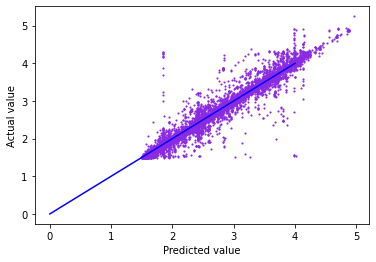

In [39]:
plot_performance(X_val_norm, log_y_val, gboost)

# Model persistence

In [42]:
notes = "Gradient Boosting Regressor. " \
         + "Trained on training, validation, and test data. " \
         + f"Grid search {'not ' if not grid_search else ''}performed. " \
         + "y values transformed with log. " \
         + "X values NOT scaled."

print(notes)

Gradient Boosting Regressor. Trained on training, validation, and test data. Grid search performed. y values transformed with log. X values NOT scaled.


In [43]:
if save_model:
    ms = model_saver('time_regr_log_gboost_final', notes,
                   gboost, df,
                   None,
                   X_features,
                   X_train, y_train_full,
                   X_val, y_val_full,
                   X_test, y_test_full)
    ms.save()